# Real Hardware Fitting

In [2]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_maps import *
from quantum_tools import *
from experiments import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Two Qubit POVM

In [55]:
n = 2
d = 2**n

input_map_list, counts_map_list, counts_rep_list, counts_corr_list = pickle.load(open("../../data/twoQubits_pauliStrings_corrMat_mock.p", "rb"))

targets_map = counts_to_probs(counts_map_list)
corr_matrix = sum([generate_corruption_matrix(counts_corr_list[i*d: (i+1)*d]) for i in range(d)])/d

In [56]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

spam_model = SPAM(
                  d=d,
                  init = init_ideal(n),
                  povm = corr_mat_to_povm(corr_matrix),
                  )

In [57]:
rank = d**2

circuit_target = variational_circuit(n).reverse_bits()
U = Operator(circuit_target).data

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

kraus_model = KrausMap(
#                       U = U,
#                       c = 0.9,
                       d = d, 
                       rank = rank,
                       spam = spam_model,
                       )

model = ModelQuantumMap(
                        q_map = kraus_model,
                        loss = probs_loss,
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

In [58]:
model.train(inputs = input_map_list,
            targets = targets_map,
            inputs_val = input_map_list,
            targets_val = targets_map,
            num_iter = 1000,
            N = 324
            )

  0%|          | 0/1000 [00:00<?, ?it/s]

Step:0, train: 0.52552, val: 0.52552
Step:1, train: 0.51973, val: 0.51973
Step:2, train: 0.51395, val: 0.51395
Step:3, train: 0.50816, val: 0.50816
Step:4, train: 0.50238, val: 0.50238
Step:5, train: 0.49659, val: 0.49659
Step:6, train: 0.49082, val: 0.49082
Step:7, train: 0.48504, val: 0.48504
Step:8, train: 0.47926, val: 0.47926
Step:9, train: 0.47348, val: 0.47348
Step:10, train: 0.46770, val: 0.46770
Step:11, train: 0.46191, val: 0.46191
Step:12, train: 0.45612, val: 0.45612
Step:13, train: 0.45033, val: 0.45033
Step:14, train: 0.44452, val: 0.44452
Step:15, train: 0.43872, val: 0.43872
Step:16, train: 0.43291, val: 0.43291
Step:17, train: 0.42710, val: 0.42710
Step:18, train: 0.42128, val: 0.42128
Step:19, train: 0.41545, val: 0.41545
Step:20, train: 0.40960, val: 0.40960
Step:21, train: 0.40373, val: 0.40373
Step:22, train: 0.39786, val: 0.39786
Step:23, train: 0.39198, val: 0.39198
Step:24, train: 0.38609, val: 0.38609
Step:25, train: 0.38019, val: 0.38019
Step:26, train: 0.3742

Step:213, train: 0.00284, val: 0.00284
Step:214, train: 0.00279, val: 0.00279
Step:215, train: 0.00274, val: 0.00274
Step:216, train: 0.00269, val: 0.00269
Step:217, train: 0.00265, val: 0.00265
Step:218, train: 0.00260, val: 0.00260
Step:219, train: 0.00255, val: 0.00255
Step:220, train: 0.00251, val: 0.00251
Step:221, train: 0.00247, val: 0.00247
Step:222, train: 0.00242, val: 0.00242
Step:223, train: 0.00238, val: 0.00238
Step:224, train: 0.00234, val: 0.00234
Step:225, train: 0.00230, val: 0.00230
Step:226, train: 0.00226, val: 0.00226
Step:227, train: 0.00223, val: 0.00223
Step:228, train: 0.00219, val: 0.00219
Step:229, train: 0.00215, val: 0.00215
Step:230, train: 0.00212, val: 0.00212
Step:231, train: 0.00208, val: 0.00208
Step:232, train: 0.00205, val: 0.00205
Step:233, train: 0.00201, val: 0.00201
Step:234, train: 0.00198, val: 0.00198
Step:235, train: 0.00195, val: 0.00195
Step:236, train: 0.00192, val: 0.00192
Step:237, train: 0.00189, val: 0.00189
Step:238, train: 0.00186,

Step:425, train: 0.00030, val: 0.00030
Step:426, train: 0.00030, val: 0.00030
Step:427, train: 0.00029, val: 0.00029
Step:428, train: 0.00029, val: 0.00029
Step:429, train: 0.00029, val: 0.00029
Step:430, train: 0.00029, val: 0.00029
Step:431, train: 0.00029, val: 0.00029
Step:432, train: 0.00029, val: 0.00029
Step:433, train: 0.00029, val: 0.00029
Step:434, train: 0.00028, val: 0.00028
Step:435, train: 0.00028, val: 0.00028
Step:436, train: 0.00028, val: 0.00028
Step:437, train: 0.00028, val: 0.00028
Step:438, train: 0.00028, val: 0.00028
Step:439, train: 0.00028, val: 0.00028
Step:440, train: 0.00028, val: 0.00028
Step:441, train: 0.00028, val: 0.00028
Step:442, train: 0.00028, val: 0.00028
Step:443, train: 0.00027, val: 0.00027
Step:444, train: 0.00027, val: 0.00027
Step:445, train: 0.00027, val: 0.00027
Step:446, train: 0.00027, val: 0.00027
Step:447, train: 0.00027, val: 0.00027
Step:448, train: 0.00027, val: 0.00027
Step:449, train: 0.00027, val: 0.00027
Step:450, train: 0.00027,

Step:636, train: 0.00018, val: 0.00018
Step:637, train: 0.00018, val: 0.00018
Step:638, train: 0.00018, val: 0.00018
Step:639, train: 0.00018, val: 0.00018
Step:640, train: 0.00018, val: 0.00018
Step:641, train: 0.00018, val: 0.00018
Step:642, train: 0.00018, val: 0.00018
Step:643, train: 0.00018, val: 0.00018
Step:644, train: 0.00018, val: 0.00018
Step:645, train: 0.00018, val: 0.00018
Step:646, train: 0.00018, val: 0.00018
Step:647, train: 0.00018, val: 0.00018
Step:648, train: 0.00018, val: 0.00018
Step:649, train: 0.00018, val: 0.00018
Step:650, train: 0.00018, val: 0.00018
Step:651, train: 0.00018, val: 0.00018
Step:652, train: 0.00018, val: 0.00018
Step:653, train: 0.00018, val: 0.00018
Step:654, train: 0.00018, val: 0.00018
Step:655, train: 0.00018, val: 0.00018
Step:656, train: 0.00018, val: 0.00018
Step:657, train: 0.00018, val: 0.00018
Step:658, train: 0.00018, val: 0.00018
Step:659, train: 0.00018, val: 0.00018
Step:660, train: 0.00018, val: 0.00018
Step:661, train: 0.00018,

Step:847, train: 0.00015, val: 0.00015
Step:848, train: 0.00015, val: 0.00015
Step:849, train: 0.00015, val: 0.00015
Step:850, train: 0.00015, val: 0.00015
Step:851, train: 0.00015, val: 0.00015
Step:852, train: 0.00015, val: 0.00015
Step:853, train: 0.00015, val: 0.00015
Step:854, train: 0.00015, val: 0.00015
Step:855, train: 0.00015, val: 0.00015
Step:856, train: 0.00015, val: 0.00015
Step:857, train: 0.00015, val: 0.00015
Step:858, train: 0.00015, val: 0.00015
Step:859, train: 0.00015, val: 0.00015
Step:860, train: 0.00015, val: 0.00015
Step:861, train: 0.00015, val: 0.00015
Step:862, train: 0.00015, val: 0.00015
Step:863, train: 0.00015, val: 0.00015
Step:864, train: 0.00015, val: 0.00015
Step:865, train: 0.00015, val: 0.00015
Step:866, train: 0.00015, val: 0.00015
Step:867, train: 0.00015, val: 0.00015
Step:868, train: 0.00015, val: 0.00015
Step:869, train: 0.00015, val: 0.00015
Step:870, train: 0.00015, val: 0.00015
Step:871, train: 0.00015, val: 0.00015
Step:872, train: 0.00015,

In [59]:
state_unitary = state_model = tf.expand_dims(model.q_map.spam.init, axis=0)

observ = np.zeros((1, d))
observ[0, 0] = 1
observ = tf.cast(observ, dtype=tf.complex128)
model_expectation_list = []
unitary_expectation_list = []

probs = counts_to_probs(counts_rep_list)
                        
target_test = expectation_value(probs, observ).numpy()

for i in range(20):
    state_model = model.q_map.apply_map(state_model)
    probs = measurement(state_model, povm=model.q_map.spam.povm)
    model_expectation_list.append(expectation_value(probs, observ))
    
    state_unitary = U@state_unitary@U.T.conj()
    unitary_expectation_list.append(expectation_value(measurement(state_unitary, povm=model.q_map.spam.povm), observ))

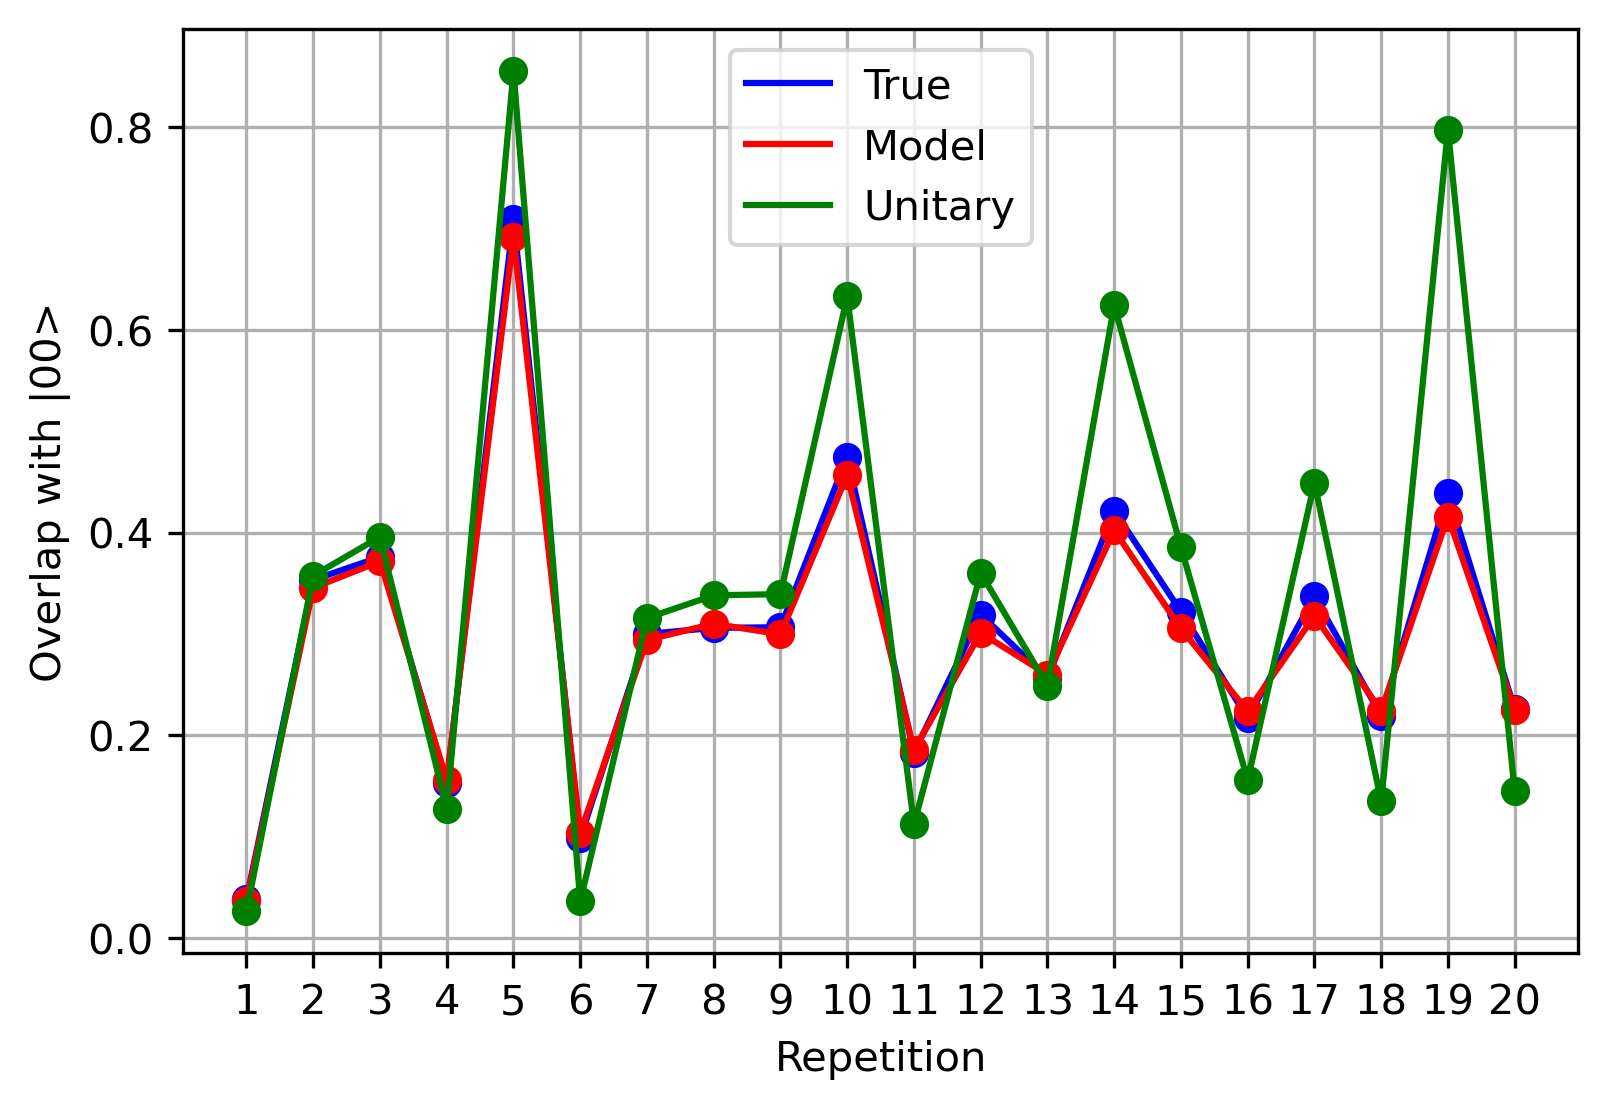

In [60]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,21))
plt.plot(x, target_test, "b-",  label="True")
plt.plot(x, target_test, "bo")

plt.plot(x, model_expectation_list, "r-", label="Model")
plt.plot(x, model_expectation_list, "ro")

plt.plot(x, unitary_expectation_list, "g-", label="Unitary")
plt.plot(x, unitary_expectation_list, "go")
plt.xlabel("Repetition")
plt.ylabel("Overlap with |00>")

plt.xticks(list(range(1,21)))
plt.legend()
plt.grid()
plt.show()

      ┌────────────┐ ┌───┐┌─────────────┐     
q_0: ─┤ Ry(2.8319) ├─┤ X ├┤ Rx(0.61989) ├──■──
     ┌┴────────────┴┐└─┬─┘└┬────────────┤┌─┴─┐
q_1: ┤ Ry(-0.78829) ├──■───┤ Rx(1.4577) ├┤ X ├
     └──────────────┘      └────────────┘└───┘


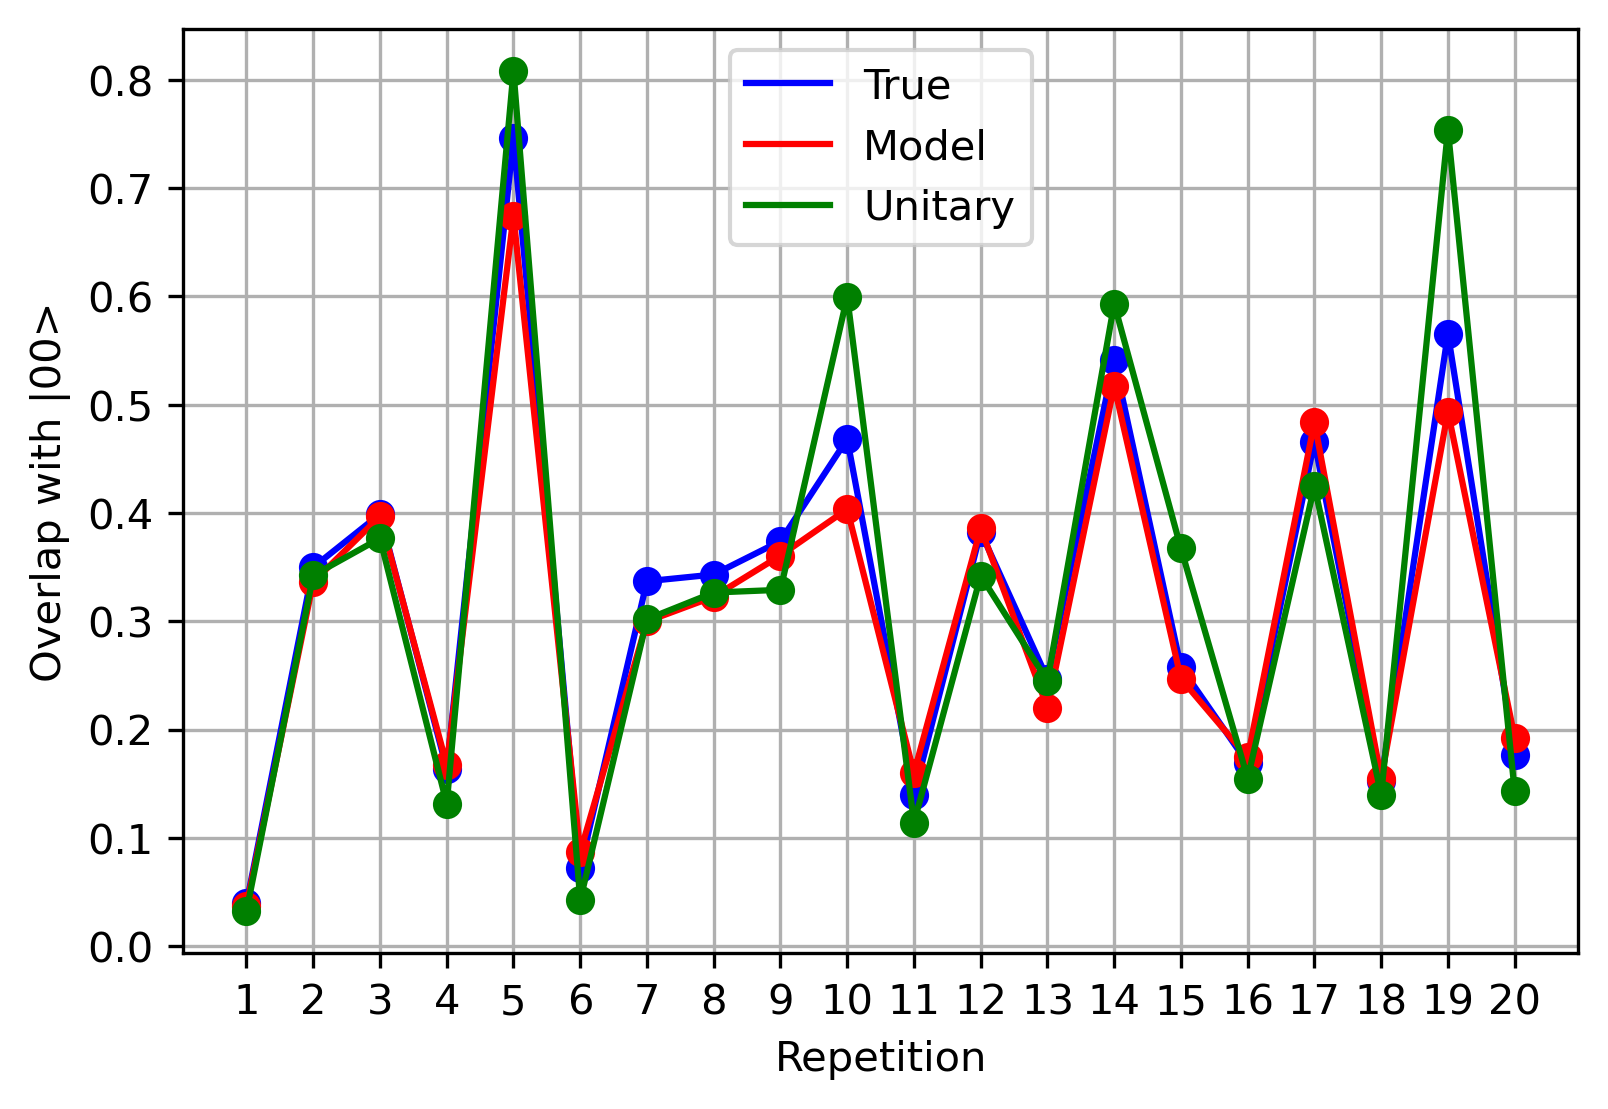

In [32]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,21))
plt.plot(x, target_test, "b-",  label="True")
plt.plot(x, target_test, "bo")

plt.plot(x, model_expectation_list, "r-", label="Model")
plt.plot(x, model_expectation_list, "ro")

plt.plot(x, unitary_expectation_list, "g-", label="Unitary")
plt.plot(x, unitary_expectation_list, "go")
plt.xlabel("Repetition")
plt.ylabel("Overlap with |00>")

plt.xticks(list(range(1,21)))
plt.legend()
plt.grid()
plt.show()

## Three Qubits 

In [74]:
n = 3
d = 2**n

input_map_list, counts_map_list, counts_rep_list, counts_corr_list = pickle.load(open("../../data/threeQubits_pauliStrings_corrMat.p", "rb"))

targets_map = counts_to_probs(counts_map_list)
corr_matrix = sum([generate_corruption_matrix(counts_corr_list[i*d: (i+1)*d]) for i in range(d)])/d

IndexError: list index out of range

In [75]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

spam_model = SPAM(
                  d=d,
                  init = init_ideal(n),
                  povm = corr_mat_to_povm(corr_matrix),
                  )

In [69]:
rank = d**2

circuit_target = variational_circuit(n).reverse_bits()
U = Operator(circuit_target).data

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

kraus_model = KrausMap(
#                       U = U,
#                       c = 0.9,
                       d = d, 
                       rank = rank,
                       spam = spam_model,
                       )

model = ModelQuantumMap(
                        q_map = kraus_model,
                        loss = probs_loss,
                        optimizer = tf.optimizers.Adam(learning_rate=0.01),
                        )

In [70]:
model.train(inputs = input_map_list,
            targets = targets_map,
            inputs_val = None,
            targets_val = None,
            num_iter = 1000,
            N = 500
            )

  0%|          | 0/1000 [00:00<?, ?it/s]

Step:0, train: 0.58796, val: 0.00000
Step:1, train: 0.58113, val: 0.00000
Step:2, train: 0.53410, val: 0.00000
Step:3, train: 0.56050, val: 0.00000
Step:4, train: 0.56358, val: 0.00000
Step:5, train: 0.57345, val: 0.00000
Step:6, train: 0.53418, val: 0.00000
Step:7, train: 0.54634, val: 0.00000
Step:8, train: 0.54215, val: 0.00000
Step:9, train: 0.54963, val: 0.00000
Step:10, train: 0.53685, val: 0.00000
Step:11, train: 0.52081, val: 0.00000
Step:12, train: 0.49562, val: 0.00000
Step:13, train: 0.52324, val: 0.00000
Step:14, train: 0.50869, val: 0.00000
Step:15, train: 0.49598, val: 0.00000
Step:16, train: 0.49777, val: 0.00000
Step:17, train: 0.47855, val: 0.00000
Step:18, train: 0.51016, val: 0.00000
Step:19, train: 0.47966, val: 0.00000
Step:20, train: 0.47472, val: 0.00000
Step:21, train: 0.45984, val: 0.00000
Step:22, train: 0.44820, val: 0.00000
Step:23, train: 0.45913, val: 0.00000
Step:24, train: 0.45724, val: 0.00000
Step:25, train: 0.46681, val: 0.00000
Step:26, train: 0.4494

Step:213, train: 0.00552, val: 0.00000
Step:214, train: 0.00517, val: 0.00000
Step:215, train: 0.00494, val: 0.00000
Step:216, train: 0.00502, val: 0.00000
Step:217, train: 0.00480, val: 0.00000
Step:218, train: 0.00461, val: 0.00000
Step:219, train: 0.00458, val: 0.00000
Step:220, train: 0.00460, val: 0.00000
Step:221, train: 0.00483, val: 0.00000
Step:222, train: 0.00438, val: 0.00000
Step:223, train: 0.00432, val: 0.00000
Step:224, train: 0.00417, val: 0.00000
Step:225, train: 0.00426, val: 0.00000
Step:226, train: 0.00400, val: 0.00000
Step:227, train: 0.00406, val: 0.00000
Step:228, train: 0.00389, val: 0.00000
Step:229, train: 0.00388, val: 0.00000
Step:230, train: 0.00380, val: 0.00000
Step:231, train: 0.00383, val: 0.00000
Step:232, train: 0.00382, val: 0.00000
Step:233, train: 0.00360, val: 0.00000
Step:234, train: 0.00355, val: 0.00000
Step:235, train: 0.00355, val: 0.00000
Step:236, train: 0.00348, val: 0.00000
Step:237, train: 0.00340, val: 0.00000
Step:238, train: 0.00336,

Step:424, train: 0.00062, val: 0.00000
Step:425, train: 0.00065, val: 0.00000
Step:426, train: 0.00059, val: 0.00000
Step:427, train: 0.00061, val: 0.00000
Step:428, train: 0.00063, val: 0.00000
Step:429, train: 0.00061, val: 0.00000
Step:430, train: 0.00061, val: 0.00000
Step:431, train: 0.00061, val: 0.00000
Step:432, train: 0.00061, val: 0.00000
Step:433, train: 0.00061, val: 0.00000
Step:434, train: 0.00059, val: 0.00000
Step:435, train: 0.00060, val: 0.00000
Step:436, train: 0.00059, val: 0.00000
Step:437, train: 0.00060, val: 0.00000
Step:438, train: 0.00059, val: 0.00000
Step:439, train: 0.00058, val: 0.00000
Step:440, train: 0.00057, val: 0.00000
Step:441, train: 0.00059, val: 0.00000
Step:442, train: 0.00058, val: 0.00000
Step:443, train: 0.00060, val: 0.00000
Step:444, train: 0.00058, val: 0.00000
Step:445, train: 0.00059, val: 0.00000
Step:446, train: 0.00057, val: 0.00000
Step:447, train: 0.00059, val: 0.00000
Step:448, train: 0.00060, val: 0.00000
Step:449, train: 0.00056,

Step:635, train: 0.00042, val: 0.00000
Step:636, train: 0.00044, val: 0.00000
Step:637, train: 0.00043, val: 0.00000
Step:638, train: 0.00044, val: 0.00000
Step:639, train: 0.00043, val: 0.00000
Step:640, train: 0.00043, val: 0.00000
Step:641, train: 0.00043, val: 0.00000
Step:642, train: 0.00044, val: 0.00000
Step:643, train: 0.00044, val: 0.00000
Step:644, train: 0.00043, val: 0.00000
Step:645, train: 0.00043, val: 0.00000
Step:646, train: 0.00042, val: 0.00000
Step:647, train: 0.00042, val: 0.00000
Step:648, train: 0.00044, val: 0.00000
Step:649, train: 0.00043, val: 0.00000
Step:650, train: 0.00042, val: 0.00000
Step:651, train: 0.00043, val: 0.00000
Step:652, train: 0.00043, val: 0.00000
Step:653, train: 0.00041, val: 0.00000
Step:654, train: 0.00043, val: 0.00000
Step:655, train: 0.00043, val: 0.00000
Step:656, train: 0.00043, val: 0.00000
Step:657, train: 0.00043, val: 0.00000
Step:658, train: 0.00043, val: 0.00000
Step:659, train: 0.00043, val: 0.00000
Step:660, train: 0.00042,

Step:846, train: 0.00035, val: 0.00000
Step:847, train: 0.00036, val: 0.00000
Step:848, train: 0.00036, val: 0.00000
Step:849, train: 0.00037, val: 0.00000
Step:850, train: 0.00037, val: 0.00000
Step:851, train: 0.00035, val: 0.00000
Step:852, train: 0.00036, val: 0.00000
Step:853, train: 0.00037, val: 0.00000
Step:854, train: 0.00035, val: 0.00000
Step:855, train: 0.00037, val: 0.00000
Step:856, train: 0.00036, val: 0.00000
Step:857, train: 0.00036, val: 0.00000
Step:858, train: 0.00036, val: 0.00000
Step:859, train: 0.00037, val: 0.00000
Step:860, train: 0.00038, val: 0.00000
Step:861, train: 0.00038, val: 0.00000
Step:862, train: 0.00035, val: 0.00000
Step:863, train: 0.00037, val: 0.00000
Step:864, train: 0.00035, val: 0.00000
Step:865, train: 0.00037, val: 0.00000
Step:866, train: 0.00036, val: 0.00000
Step:867, train: 0.00036, val: 0.00000
Step:868, train: 0.00037, val: 0.00000
Step:869, train: 0.00037, val: 0.00000
Step:870, train: 0.00036, val: 0.00000
Step:871, train: 0.00035,

In [65]:
state_unitary = state_model = tf.expand_dims(model.q_map.spam.init, axis=0)

observ = np.zeros((1, d))
observ[0, 0] = 1
observ = tf.cast(observ, dtype=tf.complex128)
model_expectation_list = []
unitary_expectation_list = []

probs = counts_to_probs(counts_rep_list)
                        
target_test = expectation_value(probs, observ).numpy()

for i in range(20):
    state_model = model.q_map.apply_map(state_model)
    probs = measurement(state_model, povm=model.q_map.spam.povm)
    model_expectation_list.append(expectation_value(probs, observ))
    
    state_unitary = U@state_unitary@U.T.conj()
    unitary_expectation_list.append(expectation_value(measurement(state_unitary, povm=model.q_map.spam.povm), observ))

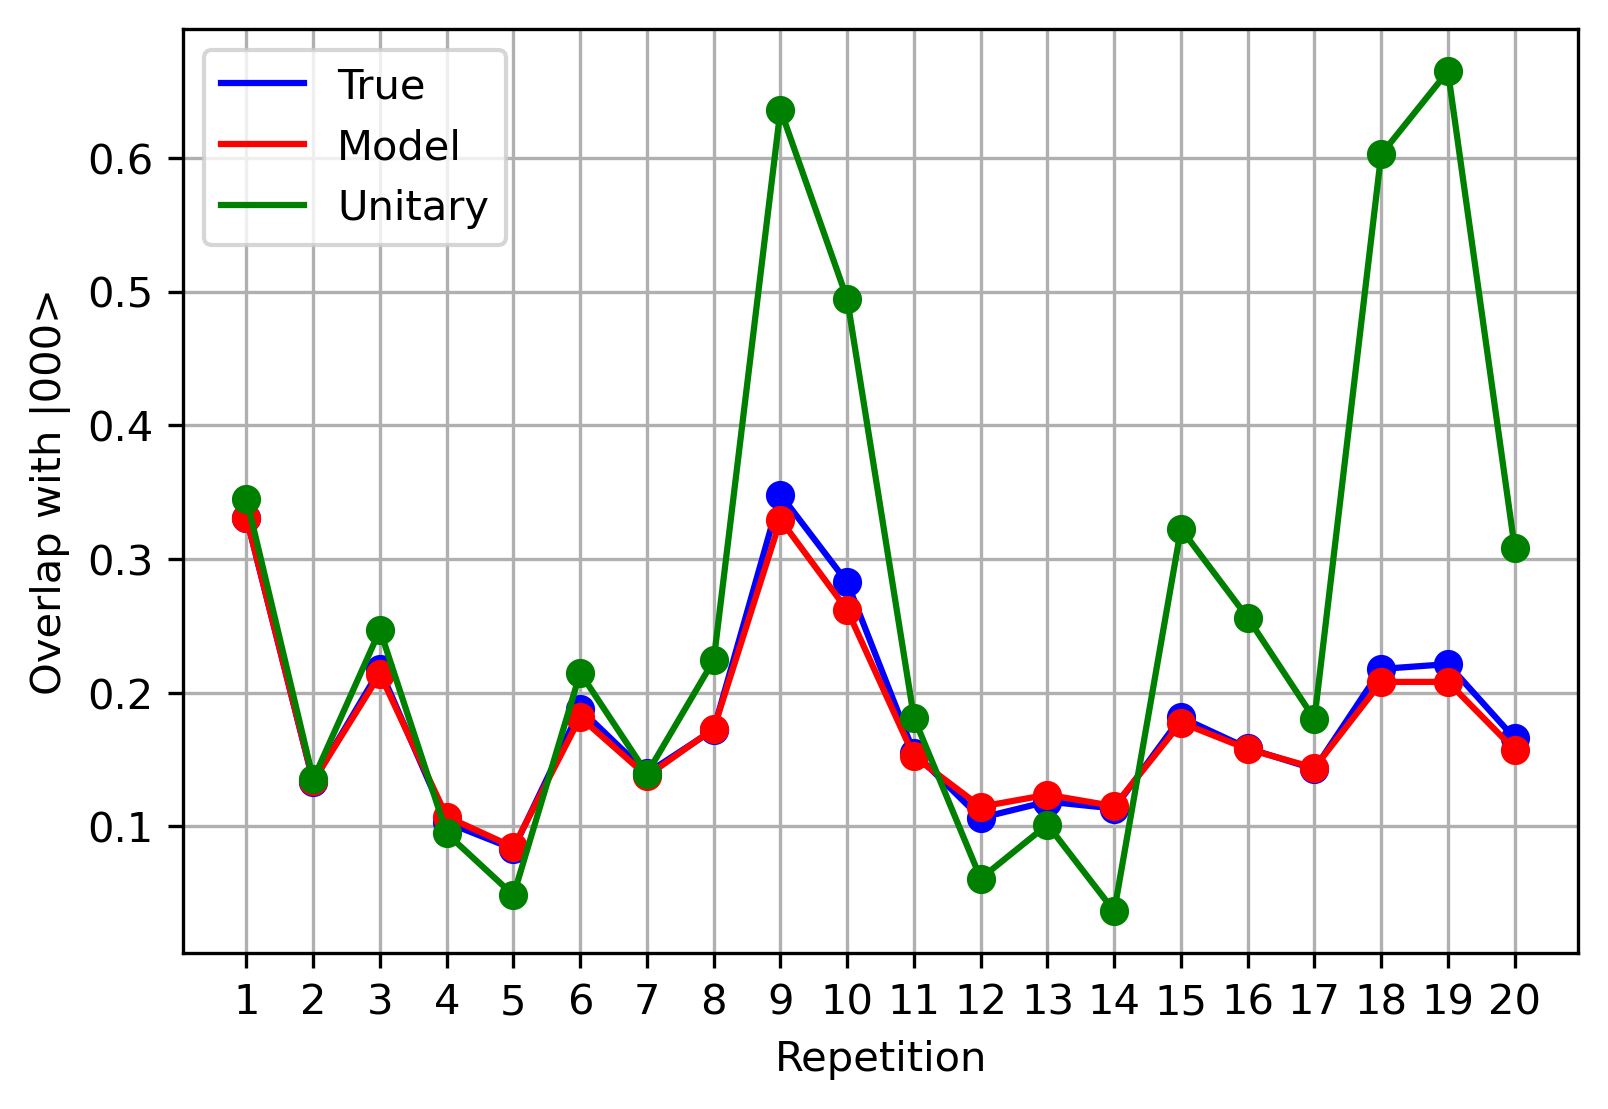

In [66]:
fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,21))
plt.plot(x, target_test, "b-",  label="True")
plt.plot(x, target_test, "bo")

plt.plot(x, model_expectation_list, "r-", label="Model")
plt.plot(x, model_expectation_list, "ro")

plt.plot(x, unitary_expectation_list, "g-", label="Unitary")
plt.plot(x, unitary_expectation_list, "go")
plt.xlabel("Repetition")
plt.ylabel("Overlap with |000>")

plt.xticks(list(range(1,21)))
plt.legend()
plt.grid()
plt.show()

      ┌────────────┐           ┌───┐     ┌─────────────┐          
q_0: ─┤ Ry(1.4577) ├───────────┤ X ├─────┤ Rx(-2.1615) ├──■───────
      ├────────────┤ ┌───┐     └─┬─┘     ├─────────────┤┌─┴─┐     
q_1: ─┤ Ry(2.8319) ├─┤ X ├───────■───────┤ Rx(-2.1613) ├┤ X ├──■──
     ┌┴────────────┴┐└─┬─┘┌─────────────┐└─────────────┘└───┘┌─┴─┐
q_2: ┤ Ry(-0.78829) ├──■──┤ Rx(0.61989) ├────────────────────┤ X ├
     └──────────────┘     └─────────────┘                    └───┘


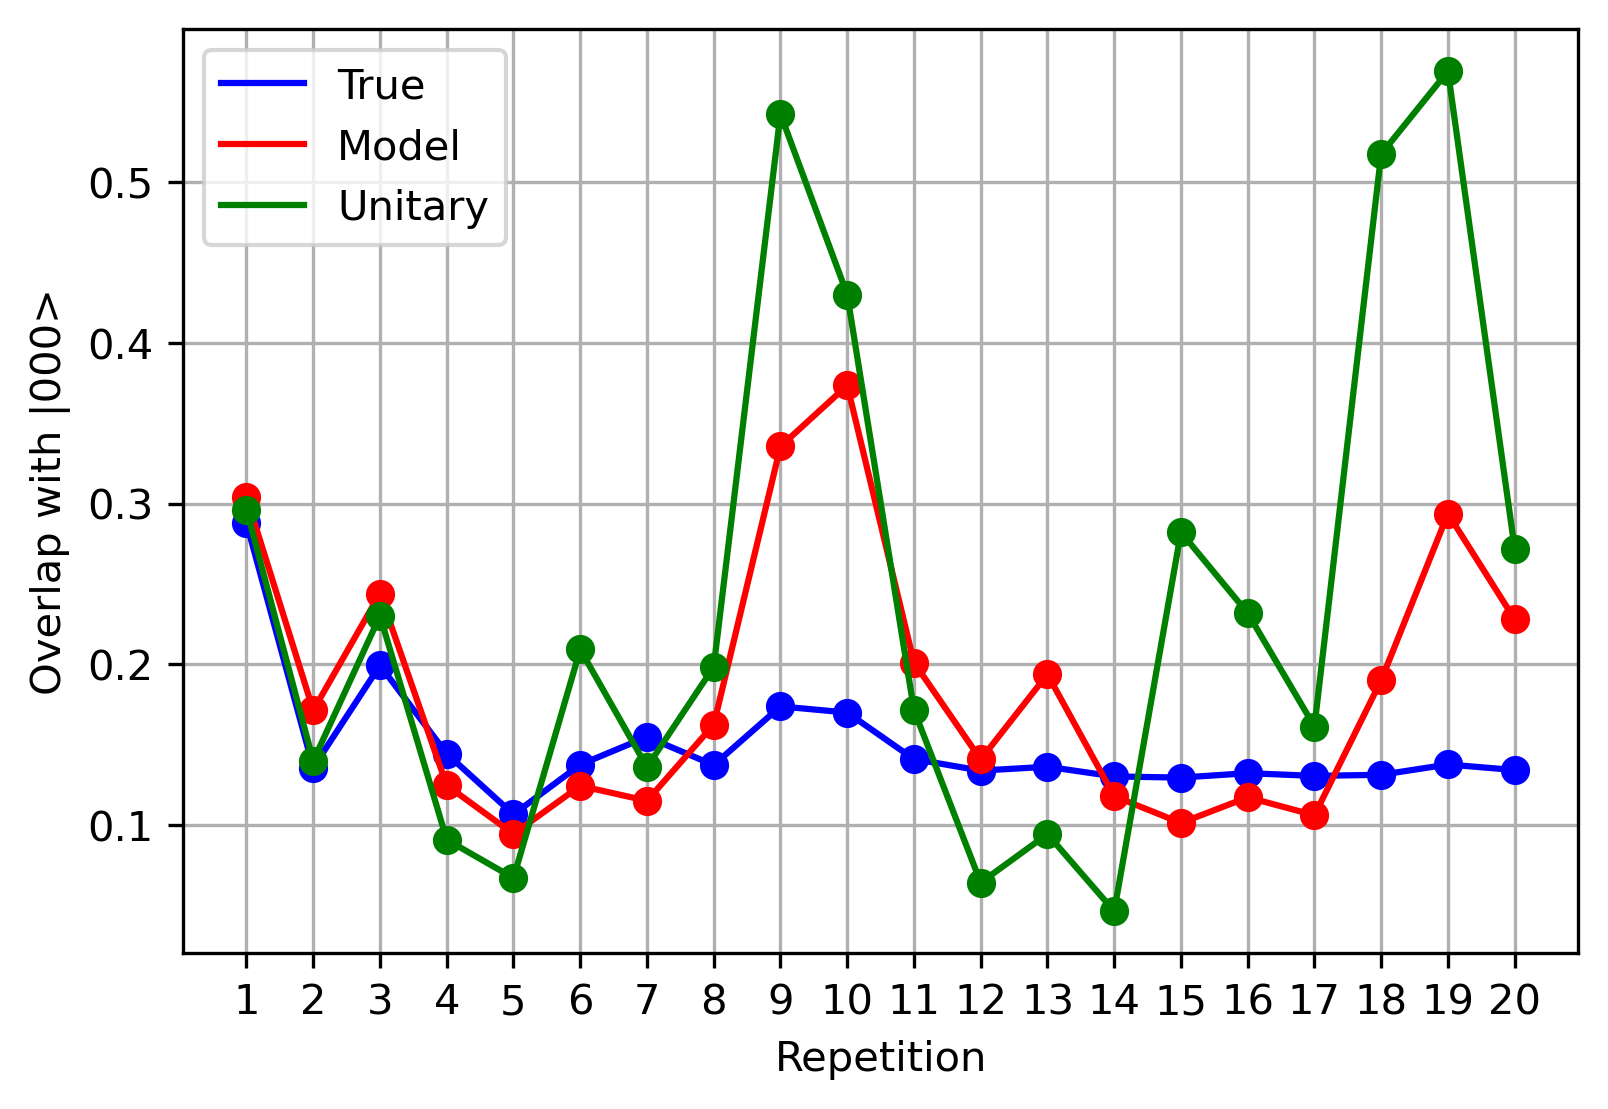

In [54]:
print(circuit_target)

fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,21))
plt.plot(x, target_test, "b-",  label="True")
plt.plot(x, target_test, "bo")

plt.plot(x, model_expectation_list, "r-", label="Model")
plt.plot(x, model_expectation_list, "ro")

plt.plot(x, unitary_expectation_list, "g-", label="Unitary")
plt.plot(x, unitary_expectation_list, "go")
plt.xlabel("Repetition")
plt.ylabel("Overlap with |000>")

plt.xticks(list(range(1,21)))
plt.legend()
plt.grid()
plt.show()

In [8]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

n = 2
d = 2**n

spam_model = SPAM(
                  d=d,
                  #init = init_ideal(n),
                  #povm = corr_mat_to_povm(corr_matrix),
                  )

In [9]:
spam_model.pretrain(num_iter = 1000, targets = [init_ideal(n), povm_ideal(n)])

  0%|          | 0/1000 [00:00<?, ?it/s]

AttributeError: 'NoneType' object has no attribute 'apply_gradients'